In [1]:
import osmnx as ox
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
import scipy

In [2]:
import os
from sodapy import Socrata

In [3]:
G = ox.graph_from_place('Manhattan Island, New York City, New York, USA', network_type='drive',simplify=True)


In [4]:
#get relevant collisions & speeds data from 2018

In [4]:
query = """
select *

where
date<'2019-01-01T00:00:00.000'
and
date>='2018-01-01T00:00:00.000'

and
borough='MANHATTAN'



limit
    50000000000
"""

In [5]:
#SQL querying collisions data from Socrata
client = Socrata("data.cityofnewyork.us", None)
results = client.get("qiz3-axqb", query=query)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [6]:
query = """
select *

where
data_as_of<'2019-01-01T00:00:00.000'
and
data_as_of>='2018-01-01T00:00:00.000'
and
borough='Manhattan'
and
speed is not null
and
link_points is not null


limit
    50000000000
"""

In [ ]:
#now for speeds data from Socrata again
client = Socrata("data.cityofnewyork.us", None)
#results = client.get("i4gi-tjb9", where="data_as_of='2017-10-19T06:58:30.000'",limit=2000000)
results = client.get("i4gi-tjb9", query=query)

# Convert to pandas DataFrame
results_df2 = pd.DataFrame.from_records(results)

In [ ]:
df_speeds=results_df2.copy()
df_coll=results_df.copy()

In [ ]:
#converting everything to proper date time format

In [ ]:
df_coll['datetime']=pd.to_datetime(df_coll['date'].astype(str)+' '+df_coll['time'].astype(str))
df_speeds['datetime']=pd.to_datetime(df_speeds['data_as_of'])

In [ ]:
df_coll['hour']=df_coll['datetime'].dt.hour
df_speeds['hour']=df_speeds['datetime'].dt.hour
df_speeds['speed']=np.array(df_speeds['speed'].values,dtype=float)
df_speeds=df_speeds.loc[df_speeds['speed']>0]

In [ ]:
df_speeds['hm']=df_speeds['hour']*60+df_speeds['datetime'].dt.minute
df_coll['hm']=df_coll['hour']*60+df_coll['datetime'].dt.minute
df_coll['dateonly']=df_coll['datetime'].dt.date
df_speeds['dateonly']=df_speeds['datetime'].dt.date
df_speeds['weekday']=df_speeds['datetime'].dt.dayofweek
df_coll['weekday']=df_coll['datetime'].dt.dayofweek


In [ ]:
#Exploratory analysis to see if collision rate (collisions/hour) is correlated with speed

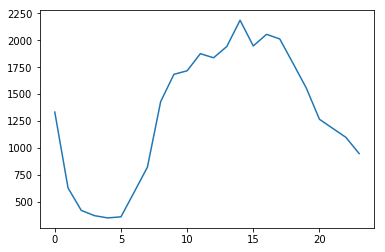

In [12]:
plt.plot(df_coll.groupby(['hour']).size())


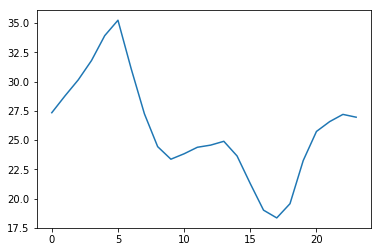

In [13]:
plt.plot(df_speeds.groupby(['hour'])['speed'].mean())

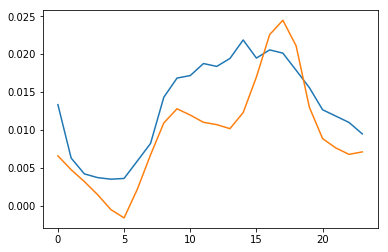

In [14]:
#some rough scaling- so that they fit on the same graph 
plt.plot(.00001*df_coll.groupby(['hour']).size())
plt.plot(-.03+1/df_speeds.groupby(['hour'])['speed'].mean())
#we are seeing that 1/speed and collision rate definitely look correlated!

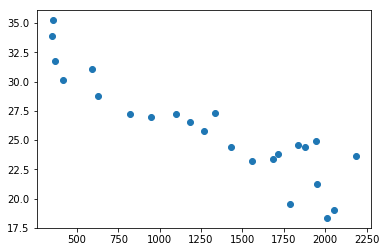

In [15]:
plt.plot(df_coll.groupby(['hour']).size(),df_speeds.groupby(['hour'])['speed'].mean(),'o')
#nice correlation! More collisions at times of day when speeds are lower

In [18]:
#Now looking at entire data set - how well can speed be predicted/ do collisions help in predicting speed?
#grouping dataset by hour and date

In [ ]:
grouped_df=df_coll.groupby(['hour','dateonly'])
df_coll_rate=pd.DataFrame(grouped_df.size().reset_index(name = "Coll_rate"))

In [ ]:
df_speeds_coll = pd.merge(df_speeds, df_coll_rate,  how='left', left_on=['hour','dateonly'], right_on = ['hour','dateonly'])

In [ ]:
data=df_speeds_coll[['hm','id','weekday','Coll_rate']]
data['speed']=df_speeds_coll['speed']
data=data.dropna()
features=data[['hm','id','weekday','Coll_rate']]
labels=data['speed']

In [ ]:
rf = RandomForestRegressor()
#lr_regressor= GridSearchCV(lr,parameters)
rf.fit(features,labels)

In [ ]:
pred=rf.predict(features)


In [71]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred,labels.values)
r_value**2


0.72848483376827444

In [54]:
w=np.where(pred<60)[0]
pred2=pred[w]
labels2=labels.values[w]
a1=np.linspace(0,len(pred2)-1,len(pred2)).astype(int)
np.random.shuffle(a1)
pred3=pred2[a1[:10000]]
labels3=labels2[a1[:10000]]


jointplotdata=pd.DataFrame({'predicted velocity':pred3,'actual velocity':labels3})


In [76]:
len(data)

2077757

In [ ]:
# r squared 0.73 with collisions, 0.66 without collisions

<Figure size 432x288 with 0 Axes>

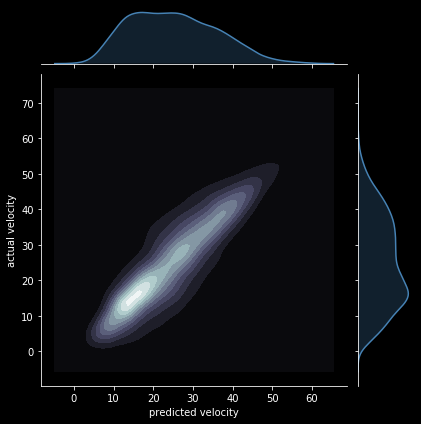

In [55]:
fig=plt.figure()
with plt.style.context('dark_background'):
    #with plt.style.context('seaborn-pastel'):
    kdefig=sns.jointplot(x="predicted velocity",y='actual velocity',data=jointplotdata,kind='kde',cmap='bone',color='steelblue')
    #hexplot = sns.jointplot(x, y, kind="hex")
    #plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
    #cax = kdefig.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
    #plt.colorbar(cax=cax)
    
    #plt.xlim(0,50)
    #plt.ylim(0,50)
    plt.savefig('vel-pred-coll2.pdf')

In [72]:
#now looking at a particular day: 1-2-2018

In [ ]:
df_speeds_coll_1218=df_speeds_coll.loc[df_speeds_coll['datetime'].dt.date==pd.to_datetime('2018-01-02').date()]


In [ ]:
df_speeds_coll_1218=df_speeds_coll_1218[['hm','id','weekday','Coll_rate','speed','link_points','hour']]

In [ ]:
df_speeds_coll_1218=df_speeds_coll_1218.dropna()

In [ ]:
data=df_speeds_coll_1218[['hm','id','weekday','Coll_rate']]
data['speed']=df_speeds_coll_1218['speed']
features=data[['hm','id','weekday','Coll_rate']]
labels=data['speed']

In [ ]:
pred=rf.predict(features)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred,labels.values)
r_value**2
df_speeds_coll_1218['speed_pred']=pred

In [163]:
r_value**2


0.81554425440785172

In [164]:
df_speeds_coll_1218['speed_pred']=pred

In [165]:
df_speeds_coll_1218.head()

,hm,id,weekday,Coll_rate,speed,link_points,hour,speed_pred
6674,2,448,1,2.0,42.87,"40.77149,-73.99423 40.7719,-73.99401 40.77481,...",0,41.309048
6675,2,364,1,2.0,29.82,"40.745726,-73.97359 40.745616,-73.97305 40.745...",0,27.666750
6676,2,119,1,2.0,37.90,"40.70631,-74.01501 40.705380,-74.01528 40.7049...",0,35.652139
6677,2,124,1,2.0,41.01,"40.68036,-74.00441001 40.6822,-74.0057201 40.6...",0,12.389750
6678,2,445,1,2.0,17.39,"40.7262006,-74.01112 40.7252805,-74.01128 40.7...",0,15.243000


In [ ]:
df_speeds_coll_1218.to_csv('df_speeds_coll_1218',index=False)

In [90]:
#now for Open Street Maps stuff!

In [166]:
df_speeds_coll_1218['id']=np.array(df_speeds_coll_1218.id.values,dtype=int)

In [167]:

grouped_df=df_speeds_coll_1218.groupby(['link_points'])
df_id_lp=pd.DataFrame(grouped_df.mean().reset_index())

In [168]:
len(df_speeds_coll_1218['hour'])/24

219.54166666666666

In [172]:
grouped_df=df_speeds_coll_1218.groupby(['link_points','hour'])
df_speeds_coll_1218_g=pd.DataFrame(grouped_df.mean().reset_index())

In [176]:
len(df_speeds_coll_1218_g)

446

In [185]:
dfNodes = df_speeds_coll_1218_g[['id', 'link_points']]
manhattan=G

In [196]:
len(idNodes)

4779

In [186]:
# Splitting the column containing all Lat/Long combinations
dfNodes['splitPoints'] = dfNodes['link_points'].apply(lambda x: x.split(' '))

# Reshaping our data frame to have a row for each Lat/Long point
idNodes = []
for x,y in zip(dfNodes['splitPoints'], dfNodes['id']):
    for a in np.arange(len(x)):
        idNodes.append((y, x[a]))
dfNodes = pd.DataFrame(idNodes, columns=['id', 'LatLong'])

dfNodes = dfNodes.replace('', np.NaN).dropna()

# Parsing Lat/Long into individual columns
# Longitude has an if statement since some records contain '-' for longitude
dfNodes['Latitude'] = dfNodes['LatLong'].apply(lambda x: x.split(',')[0])
dfNodes['Longitude'] = dfNodes['LatLong'] \
    .apply(lambda x: x.split(',')[1] if len(x.split(',')) > 1 else None)

# Dropping incorrect longitude records and converting everything to floats
dfNodes = dfNodes[dfNodes['Longitude'] != '-'][['id', 'Latitude', 'Longitude']].astype(float)

# Obtaining the nearest nodes in the network from the Lat/Long points
nodes = []
for row in dfNodes.iterrows():
    nearest_node = ox.get_nearest_node(manhattan, (dfNodes['Latitude'].ix[row], 
                                                   dfNodes['Longitude'].ix[row]))
    nodes.append(nearest_node)
dfNodes['Node'] = nodes

# Removing duplicate nodes
dfNodes.drop_duplicates(subset='Node', inplace=True)

dfNodes.head()

C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Users\Skanda\Anaconda3\lib\site-packages\osmnx\utils.py:382: R

,id,Latitude,Longitude,Node
0,124.0,40.680360,-74.00441,4.145735e+09
2,124.0,40.683700,-74.00644,3.708807e+08
4,124.0,40.694120,-74.01288,6.079114e+08
7,124.0,40.703434,-74.01561,4.244435e+07
8,124.0,40.704990,-74.01519,5.885468e+08


In [192]:
len(np.unique(df_speeds_coll_1218_g['id'].values))

24

In [197]:
#trying....

In [204]:
df=df_speeds_coll_1218_g.loc[df_speeds_coll_1218_g['hour']==16]
df['id'] = df['id'].astype(float)
df['id'] = df['id'].astype(float)
df = df.merge(dfNodes, on ='id')
len(df)

C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


154

In [ ]:

        # Merging in the nodes
df['id'] = df['id'].astype(float)  # Converting for the merge
df = df.merge(dfNodes, on ='id')

        # Mapping the nodes to speed categories
df['speed'] = df['speed'].astype(float)
slow = []
medium = []
fast = []
for row in df.iterrows():
    speed = df['speed'].ix[row]
    node = df['Node'].ix[row]
    


C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':
C:\Users\Skanda\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [ ]:
            # Speeds in MPH
    if speed >= 40:
        fast.append(node)
    if speed < 40 and speed >= 20:
        medium.append(node)
    if speed < 20:
        slow.append(node)
        
        # Setting the node color based on the speed categories
nc = ['g' if node in fast
        else ('y' if node in medium
        else ('r' if node in slow 
        else 'None'))
        for node in manhattan.nodes()]

        # Timestamp

        # Plotting the map
        #fig, ax = ox.plot_graph(manhattan_projected, fig_height=10, node_size=8, 
         #                       node_alpha=1,edge_linewidth=0.2, dpi=100, node_color=nc)

In [ ]:
fig, ax = ox.plot_graph(manhattan_projected, fig_height=10, node_size=8, 
         #                       node_alpha=1,edge_linewidth=0.2, dpi=100, node_color=nc)